In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
from tensorflow.keras.applications import MobileNet
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D, Flatten, Dense, Dropout, Activation, BatchNormalization, GlobalAveragePooling2D
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import plotly.figure_factory as ff

In [2]:
# Paths for training and testing datasets
train_path = "/kaggle/input/archive/train"
test_path = "/kaggle/input/archive/test"

IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 64
EPOCHS = 40
LR = 0.0002
NUM_CLASSES = 7
PATIENCE = 4  # Early stopping patience
CLASS_LABELS = ['Surprise', 'Fear', 'Anger', 'Neutral', 'Sadness', 'Disgust', 'Happy']

In [3]:
# Data augmentation for training and validation
train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   rescale=1./255,
                                   validation_split=0.2,
                                   rotation_range=10)

# Load training and validation data
train_generator = train_datagen.flow_from_directory(
                        directory=train_path,
                        target_size=(IMG_HEIGHT, IMG_WIDTH),
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        class_mode="categorical",
                        subset="training",
                        seed=12
                    )

validation_generator = train_datagen.flow_from_directory(
                        directory=train_path,
                        target_size=(IMG_HEIGHT, IMG_WIDTH),
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        class_mode="categorical",
                        subset="validation",
                        seed=12
                    )

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
                        directory=test_path,
                        target_size=(IMG_HEIGHT, IMG_WIDTH),
                        batch_size=BATCH_SIZE,
                        class_mode="categorical",
                        shuffle=False
                    )


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [4]:
# Class distribution plot
ctg = os.listdir(train_path)
counts = []
for e in ctg:
    counts.append(len(os.listdir(train_path + f'/{e}')))
df_hist = pd.DataFrame()
df_hist['category'] = CLASS_LABELS
df_hist['count'] = counts
px.bar(df_hist, x='category', y='count')

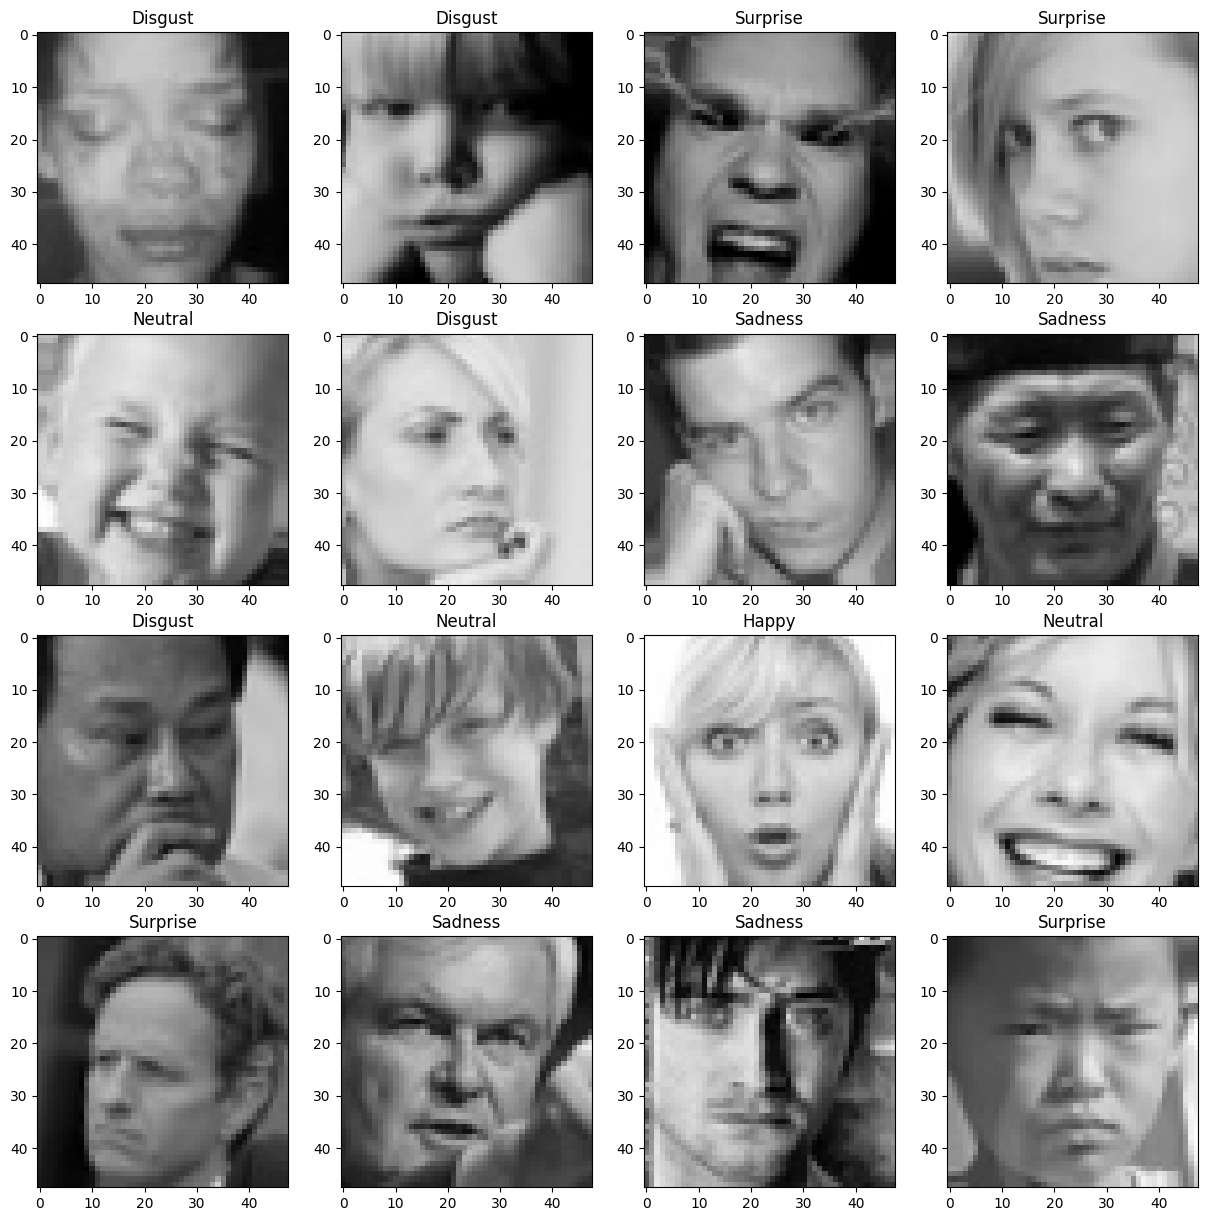

In [5]:
# Show a batch of images
imgs, labels = next(validation_generator)
validation_generator.reset()

plt.figure(figsize=(15, 15))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(imgs[i])
    plt.title(CLASS_LABELS[np.argmax(labels[i])])
plt.show()

In [6]:
# Resize image dimensions for pre-trained model (MobileNet)
IMG_HEIGHT = 224
IMG_WIDTH = 224

train_generator = train_datagen.flow_from_directory(
                        directory=train_path,
                        target_size=(IMG_HEIGHT, IMG_WIDTH),
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        class_mode="categorical",
                        subset="training",
                        seed=12
                    )

validation_generator = train_datagen.flow_from_directory(
                        directory=train_path,
                        target_size=(IMG_HEIGHT, IMG_WIDTH),
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        class_mode="categorical",
                        subset="validation",
                        seed=12
                    )

test_generator = test_datagen.flow_from_directory(
    directory=test_path,  
    target_size=(IMG_HEIGHT, IMG_WIDTH),  
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,  
    seed=12
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [7]:
# Load MobileNet base model and freeze layers for pre-training
base_model = MobileNet(include_top=False, pooling='max', weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.layers[-2].output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
out = Dense(7, activation='softmax')(x)

pretrained_model = Model(inputs=base_model.input, outputs=out)

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
# Compile pre-trained model
pretrained_model.compile(
    optimizer=Adam(learning_rate=LR), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [9]:
# Callbacks for early stopping and checkpoint saving
checkpoint = ModelCheckpoint("checkpoint_weights.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)

CALLBACKS = [early_stopping, checkpoint]

In [10]:
# Train pre-trained model
history = pretrained_model.fit(
    x=train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=CALLBACKS
)

Epoch 1/40


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.

I0000 00:00:1734245927.166116     136 service.cc:145] XLA service 0x7fecf80020a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734245927.166171     136 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734245927.166177     136 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  2/359 ━━━━━━━━━━━━━━━━━━━━ 18s 52ms/step - accuracy: 0.1094 - loss: 2.2738   

I0000 00:00:1734245935.489918     136 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3298 - loss: 1.7041
Epoch 1: val_accuracy improved from -inf to 0.43843, saving model to checkpoint_weights.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 476s 1s/step - accuracy: 0.3300 - loss: 1.7037 - val_accuracy: 0.4384 - val_loss: 1.4678
Epoch 2/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 652ms/step - accuracy: 0.4692 - loss: 1.4084
Epoch 2: val_accuracy improved from 0.43843 to 0.47326, saving model to checkpoint_weights.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 299s 819ms/step - accuracy: 0.4692 - loss: 1.4083 - val_accuracy: 0.4733 - val_loss: 1.3863
Epoch 3/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 653ms/step - accuracy: 0.4967 - loss: 1.3268
Epoch 3: val_accuracy improved from 0.47326 to 0.48006, saving model to checkpoint_weights.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 299s 821ms/step - accuracy: 0.4967 - loss: 1.3268 - val_accuracy: 0.4801 - val_loss: 1.3694
Epoch 4/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - accuracy: 0.5100 - loss: 1.2930
Epoch 4: val_a

In [11]:
# Plot analysis for pre-trained model
def plot_analysis(m):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(m.history['loss'], color="#E74C3C")
    plt.plot(m.history['val_loss'], color='#641E16')
    plt.title('Validation loss vs Train loss', fontsize=8)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.subplot(1, 2, 2)
    plt.plot(m.history['accuracy'], color="#E74C3C")
    plt.plot(m.history['val_accuracy'], color='#641E16')
    plt.title('Validation accuracy vs Train accuracy', fontsize=8)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')

    plt.show()

In [12]:
# Save the pre-trained model
pretrained_model.save('./model/pretrained_model.h5')

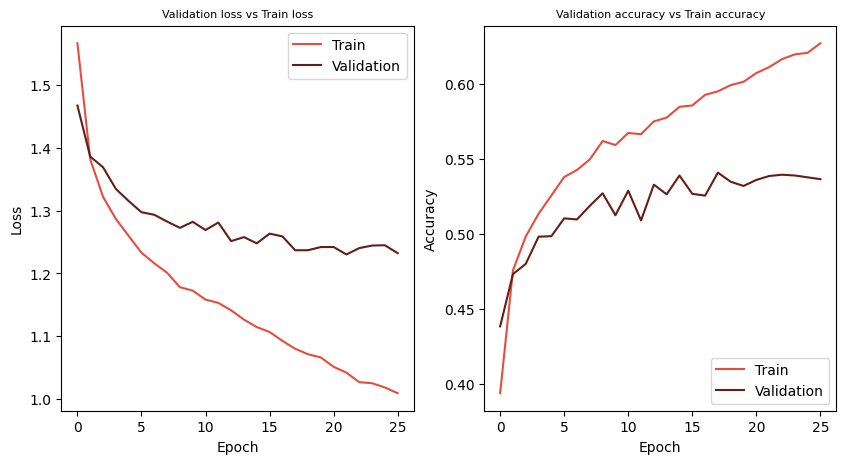

In [13]:
# Plot loss and accuracy
plot_analysis(history)

In [14]:
# Evaluate pre-trained model on test set
e = pretrained_model.evaluate(x=test_generator, verbose=1)

113/113 ━━━━━━━━━━━━━━━━━━━━ 58s 517ms/step - accuracy: 0.4677 - loss: 1.3788


In [15]:
# Generate confusion matrix and classification report for pre-trained model
test_generator.reset()
p = pretrained_model.predict(test_generator)
test_generator.reset()
labels_test = [CLASS_LABELS[item] for item in test_generator.labels]
labels_pred = [CLASS_LABELS[np.argmax(item)] for item in p]

# Print classification report
print(classification_report(labels_test, labels_pred))

113/113 ━━━━━━━━━━━━━━━━━━━━ 18s 143ms/step
              precision    recall  f1-score   support

       Anger       0.42      0.28      0.34      1024
     Disgust       0.42      0.53      0.47      1247
        Fear       0.48      0.26      0.34       111
       Happy       0.73      0.62      0.67       831
     Neutral       0.72      0.79      0.76      1774
     Sadness       0.47      0.54      0.50      1233
    Surprise       0.47      0.38      0.42       958

    accuracy                           0.55      7178
   macro avg       0.53      0.49      0.50      7178
weighted avg       0.55      0.55      0.54      7178



In [16]:
# Confusion matrix plot for pre-trained model
cfm = confusion_matrix(labels_test, labels_pred)
fig = ff.create_annotated_heatmap(np.flipud(cfm), x=CLASS_LABELS, y=list(np.flip(CLASS_LABELS)), colorscale='Purples')

fig.update_layout(
    title_text='<i><b>Confusion matrix (Pre-trained)</b></i>',
    xaxis=dict(title='Predicted label'),
    yaxis=dict(title='True label'),
    margin=dict(t=100, l=100),
    width=750,
    height=750
)
fig['data'][0]['showscale'] = True
fig.show()

In [17]:
# Fine-tuning the model (unfreeze base model layers)
base_model.trainable = True
finetunned_model = Model(inputs=base_model.input, outputs=out)

# Load best weights from checkpoint
finetunned_model.load_weights("/kaggle/working/checkpoint_weights.keras")

# Compile fine-tuned model
finetunned_model.compile(
    optimizer=Adam(learning_rate=LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train fine-tuned model
history = finetunned_model.fit(
    x=train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=CALLBACKS
)

Epoch 1/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 694ms/step - accuracy: 0.4926 - loss: 1.3567
Epoch 1: val_accuracy did not improve from 0.54085
359/359 ━━━━━━━━━━━━━━━━━━━━ 343s 870ms/step - accuracy: 0.4927 - loss: 1.3563 - val_accuracy: 0.4963 - val_loss: 1.3242
Epoch 2/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 658ms/step - accuracy: 0.6470 - loss: 0.9577
Epoch 2: val_accuracy improved from 0.54085 to 0.59537, saving model to checkpoint_weights.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 301s 825ms/step - accuracy: 0.6470 - loss: 0.9577 - val_accuracy: 0.5954 - val_loss: 1.1004
Epoch 3/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - accuracy: 0.7006 - loss: 0.8033
Epoch 3: val_accuracy did not improve from 0.59537
359/359 ━━━━━━━━━━━━━━━━━━━━ 301s 826ms/step - accuracy: 0.7006 - loss: 0.8034 - val_accuracy: 0.5820 - val_loss: 1.1898
Epoch 4/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 655ms/step - accuracy: 0.7416 - loss: 0.7026
Epoch 4: val_accuracy improved from 0.59537 to 0.60930, saving model to checkpoint_wei

In [18]:
# Save fine-tuned model
finetunned_model.save('./model/finetunned_model.h5')

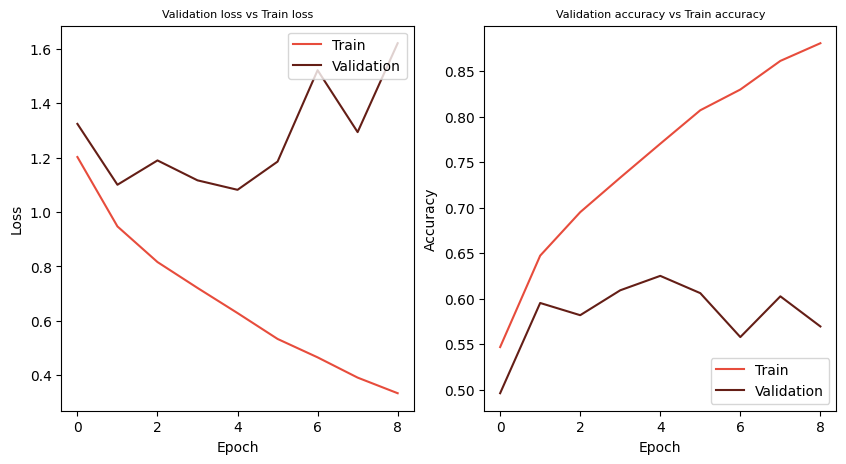

In [19]:
# Plot loss and accuracy for fine-tuned model
plot_analysis(history)

In [20]:
# Evaluate fine-tuned model on test set
e = finetunned_model.evaluate(x=test_generator, verbose=1)

113/113 ━━━━━━━━━━━━━━━━━━━━ 22s 199ms/step - accuracy: 0.6029 - loss: 1.1894


In [21]:
# Generate confusion matrix and classification report for fine-tuned model
test_generator.reset()
p = finetunned_model.predict(test_generator)
test_generator.reset()
labels_test = [CLASS_LABELS[item] for item in test_generator.labels]
labels_pred = [CLASS_LABELS[np.argmax(item)] for item in p]

# Print classification report
print(classification_report(labels_test, labels_pred))

113/113 ━━━━━━━━━━━━━━━━━━━━ 17s 139ms/step
              precision    recall  f1-score   support

       Anger       0.42      0.53      0.47      1024
     Disgust       0.56      0.47      0.51      1247
        Fear       0.63      0.48      0.54       111
       Happy       0.68      0.79      0.73       831
     Neutral       0.75      0.90      0.82      1774
     Sadness       0.65      0.44      0.53      1233
    Surprise       0.63      0.53      0.58       958

    accuracy                           0.63      7178
   macro avg       0.62      0.59      0.60      7178
weighted avg       0.63      0.63      0.62      7178



In [22]:
# Confusion matrix plot for fine-tuned model
cfm = confusion_matrix(labels_test, labels_pred)
fig = ff.create_annotated_heatmap(np.flipud(cfm), x=CLASS_LABELS, y=list(np.flip(CLASS_LABELS)), colorscale='Purples')

fig.update_layout(
    title_text='<i><b>Confusion matrix (Fine-tuned)</b></i>',
    xaxis=dict(title='Predicted label'),
    yaxis=dict(title='True label'),
    margin=dict(t=100, l=100),
    width=750,
    height=750
)
fig['data'][0]['showscale'] = True
fig.show()
